In [ ]:
!pip install transformers
#BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese')でエラーが出る
!pip install fugashi 
!pip install ipadic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 31.8 MB/s 
     |████████████████████████████████| 163 kB 70.0 MB/s 
     |████████████████████████████████| 6.6 MB 57.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 583 kB 28.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.4 MB 32.9 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=d73877a884d8eaa3aecc8781d90379289f2122d1acf6f4e028d92e835c93e272
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import math
import numpy as np
import os, random
import re
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import torchtext
from transformers import BertJapaneseTokenizer
from transformers import BertModel, BertConfig
import pickle
import  matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
tknz = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese')
#bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese')
bertv2 = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-v2')

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/104 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch
from torch.utils.data import Dataset

class DigitDataSet(Dataset):
    #__init__, __len__, __getitem__の3つの関数を
    #定義することが必要
    def __init__(self, X, Y):
        self.training_data = X
        self.label_data = Y
    
    def __len__(self):
        return len(self.training_data)
    
    def __getitem__(self,idx):
        return self.training_data[idx], self.label_data[idx]


In [ ]:
# class MyLSTM(nn.Module):
#     def __init__(self, vocsize, hdim):
#         super(MyLSTM, self).__init__()
#         self.embd = nn.Embedding(vocsize, hdim)
#         self.lstm = nn.LSTM(input_size=hdim, hidden_size=hdim)
#         self.ln   = nn.Linear(hdim, vocsize)
#         self.softmax = nn.Softmax(dim=1)
#     def forward(self, x):
#         x = self.embd(x)
#         lo, (hn, cn) = self.lstm(x)
#         out = self.softmax(self.ln(lo))

#         return out
# class MyBiLSTM(nn.Module):
#     def __init__(self, vocsize, hdim):
#         super(MyBiLSTM, self).__init__()
#         self.embd = nn.Embedding(vocsize, hdim)
#         self.lstm = nn.LSTM(input_size=hdim, hidden_size=hdim, num_layers=2,
#                             bidirectional=True)
#         self.ln   = nn.Linear(hdim*2, vocsize) #出力数が2倍になる
#         #self.softmax = nn.Softmax(dim=1)
#     def forward(self, x):
#         x = self.embd(x)
#         lo, (hn, cn) = self.lstm(x)
#         #out = self.softmax(self.ln(lo))
#         out = self.ln(lo)

#         return out

In [ ]:
class MyBERT(nn.Module):
    
    def __init__(self, bert, vocab_size):
        super(MyBERT, self).__init__()
        self.bert = bert
        self.vocab_size = vocab_size
        self.ln = nn.Linear(768, vocab_size)
    
    def forward(self, x):
        b_out = self.bert(x)
        bs = len(b_out[0])
        h0 = [ b_out[0][i][0] for i in range(bs)]
        h0 = torch.stack(h0, dim=0)
        return self.ln(h0)

In [ ]:

#txt:分ち書きされた俳句のテキストデータへのpath. 今回はstatic/haiku_wakatigaki.txtを利用。
txt="haiku_wakatigaki.txt"

In [ ]:
data = open(txt, 'r').read()
data = re.sub(r'\n', '', data)
L = [i for i in data.split()]
vocabs = set(L)

In [ ]:
#コーパスの作成
word2id = {}
for i,word in enumerate(vocabs):
    word2id[word] = i

#word2id = {word: id for id, word in enumerate(vocabrary)}
id2word = {v:k for k,v in word2id.items()}
print(len(word2id))
print(len(id2word))

425
425


In [ ]:
Xcorps = L[:-1]
Tcorps = L[1:]

dataset = DigitDataSet(Xcorps, Tcorps)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=20)

In [ ]:
vocab_size = len(vocabs)
model = MyBERT(bertv2, vocab_size).to(device)
opt = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
losses = []

model.train()

for epoch in range(1, 201):
    total_loss = 0
    for inputs, target in dataloader:
        inputs = torch.tensor([word2id[word] for word in inputs]).unsqueeze(1).to(device)
        target = torch.tensor([word2id[word] for word in target]).to(device)
        #print(inputs.size(), inputs)
        #print(target.size(), target)
        model.zero_grad()

        outputs = model(inputs)

        #target_sq = target.squeeze_()
        
        loss = criterion(outputs, target)
        loss.backward()
        opt.step()

        total_loss += loss.item()
    losses.append(total_loss)
    print(epoch, total_loss)
    if epoch%20==0:
        model_path = f'model_{epoch}.pth'
        torch.save(model.state_dict(), model_path)

1 168.67699074745178
2 161.85371351242065
3 156.2131711244583
4 151.11042833328247
5 145.60164785385132
6 140.5752490758896
7 136.33901393413544
8 132.2818877696991
9 129.334437251091
10 123.54244244098663
11 119.70200705528259
12 116.98176062107086
13 114.57322269678116
14 111.89635932445526
15 108.78805285692215
16 106.80520486831665
17 104.68291783332825
18 101.80950379371643
19 100.62622964382172
20 97.56460970640182
21 96.72818386554718
22 95.26769697666168
23 92.48096489906311
24 91.95702284574509
25 91.2308360338211
26 89.46877712011337
27 88.27801835536957
28 86.83113944530487
29 85.58219063282013
30 84.750253200531
31 83.46074897050858
32 82.75235521793365
33 82.66381418704987
34 81.54114419221878
35 81.10253703594208
36 80.06290036439896
37 79.12794560194016
38 78.6443138718605
39 77.56355994939804
40 77.1760288476944
41 76.07751476764679
42 76.48043459653854
43 75.59334170818329
44 77.3355815410614
45 74.68092429637909
46 74.21261441707611
47 74.05484318733215
48 73.84512263

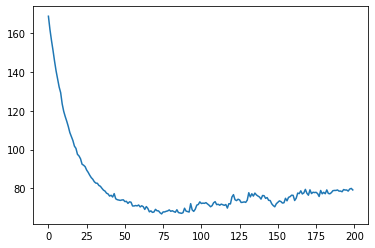

In [ ]:
plt.plot(losses)

In [ ]:
load_model = MyBERT(bertv2, vocab_size).to(device)
load_model.load_state_dict(torch.load("/content/model_80.pth"))

<All keys matched successfully>

In [ ]:
initial_id = random.choice(list(word2id.values()))
print(initial_id)
outs = [initial_id]
sample_size=10
skip_id = [word2id['。']] #ドット(.)だと終了
m = nn.Softmax(dim=1)
cnt = 0
while len(outs) < sample_size:
    x = np.array(outs[cnt]).reshape(1,1)
    x = torch.from_numpy(x).type("torch.LongTensor")
    pred = load_model(x.to(device))
    #print(pred.size())
    #print(pred.squeeze(dim=0).size())
    #softmax = m(pred.squeeze(dim=0))
    #print(max(softmax))
    #max_id = int(torch.argmax(softmax))
    max_id = int(torch.argmax(pred.squeeze(dim=0)))
    outs.append(max_id)
    cnt+=1
    if max_id in skip_id:
        break

print(outs)
gen_text = [id2word[id] for id in outs]
print(gen_text)

140
[140, 204, 214, 363, 238]
['事', 'の', '方', 'へ', '。']


In [ ]:
torch.__version__

'1.12.1+cu113'